In [0]:
# Importing Libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import tensorflow as tf
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from keras.models import load_model

In [310]:
# Reading Data

df = pd.read_excel("/content/drive/My Drive/Colab Notebooks/BreastCancer_Prognostic_v1.xlsx")
df.head(10)

,ID,Outcome,Time,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_std_dev,texture_std_dev,perimeter_std_dev,area_std_dev,smoothness_std_dev,compactness_std_dev,concavity_std_dev,concave_points_std_dev,symmetry_std_dev,fractal_dimension_std_dev,Worst_radius,Worst_texture,Worst_perimeter,Worst_area,Worst_smoothness,Worst_compactness,Worst_concavity,Worst_concave_points,Worst_symmetry,Worst_fractal_dimension,Tumor_Size,Lymph_Node_Status
0,119513,N,31,18.02,27.60,117.50,1013.0,0.09489,0.1036,0.10860,0.07055,0.1865,0.06333,0.6249,1.8900,3.972,71.55,0.004433,0.01421,0.03233,0.009854,0.01694,0.003495,21.63,37.08,139.70,1436.0,0.1195,0.1926,0.3140,0.1170,0.2677,0.08113,5.0,5
1,8423,N,61,17.99,10.38,122.80,1001.0,0.11840,0.2776,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.015870,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,3.0,2
2,842517,N,116,21.37,17.44,137.50,1373.0,0.08836,0.1189,0.12550,0.08180,0.2333,0.06010,0.5854,0.6105,3.928,82.15,0.006167,0.03449,0.03300,0.018050,0.03094,0.005039,24.90,20.98,159.10,1949.0,0.1188,0.3449,0.3414,0.2032,0.4334,0.09067,2.5,0
3,843483,N,123,11.42,20.38,77.58,386.1,0.14250,0.2839,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.018670,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,2.0,0
4,843584,R,27,20.29,14.34,135.10,1297.0,0.10030,0.1328,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.018850,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,3.5,0
5,843786,R,77,12.75,15.29,84.60,502.7,0.11890,0.1569,0.16640,0.07666,0.1995,0.07164,0.3877,0.7402,2.999,30.85,0.007775,0.02987,0.04561,0.013570,0.01774,0.005114,15.51,20.37,107.30,733.2,0.1706,0.4196,0.5999,0.1709,0.3485,0.11790,2.5,0
6,844359,N,60,18.98,19.61,124.40,1112.0,0.09087,0.1237,0.12130,0.08910,0.1727,0.05767,0.5285,0.8434,3.592,61.21,0.003703,0.02354,0.02222,0.013320,0.01378,0.003926,23.39,25.45,152.60,1593.0,0.1144,0.3371,0.2990,0.1922,0.2726,0.09581,1.5,?
7,844582,R,77,13.71,20.83,90.20,577.9,0.11890,0.1645,0.09366,0.05985,0.2196,0.07451,0.5835,1.3770,3.856,50.96,0.008805,0.03029,0.02488,0.014480,0.01486,0.005412,17.06,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510,4.0,10
8,844981,N,119,13.00,21.82,87.50,519.8,0.12730,0.1932,0.18590,0.09353,0.2350,0.07389,0.3063,1.0020,2.406,24.32,0.005731,0.03502,0.03553,0.012260,0.02143,0.003749,15.49,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720,2.0,1
9,845010,N,76,12.46,24.04,83.97,475.9,0.11860,0.2396,0.22730,0.08543,0.2030,0.08243,0.2976,1.5990,2.039,23.94,0.007149,0.07217,0.07743,0.014320,0.01789,0.010080,15.09,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750,6.0,20


In [311]:
# Checking for null values

df.isnull().sum()

ID                           0
Outcome                      0
Time                         0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave_points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_std_dev               0
texture_std_dev              0
perimeter_std_dev            0
area_std_dev                 0
smoothness_std_dev           0
compactness_std_dev          0
concavity_std_dev            0
concave_points_std_dev       0
symmetry_std_dev             0
fractal_dimension_std_dev    0
Worst_radius                 0
Worst_texture                0
Worst_perimeter              0
Worst_area                   0
Worst_smoothness             0
Worst_compactness            0
Worst_concavity              0
Worst_concave_points         0
Worst_symmetry               0
Worst_fr

In [312]:
# Filling the missing value in 'Lymph_Node_Status' column

m = df[df['Lymph_Node_Status'] != df['Lymph_Node_Status'][6]]['Lymph_Node_Status'].mean()
df['Lymph_Node_Status'] = df['Lymph_Node_Status'].replace(df['Lymph_Node_Status'][6], m)
df['Lymph_Node_Status'] = df['Lymph_Node_Status'].astype(float)

df.head()

,ID,Outcome,Time,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_std_dev,texture_std_dev,perimeter_std_dev,area_std_dev,smoothness_std_dev,compactness_std_dev,concavity_std_dev,concave_points_std_dev,symmetry_std_dev,fractal_dimension_std_dev,Worst_radius,Worst_texture,Worst_perimeter,Worst_area,Worst_smoothness,Worst_compactness,Worst_concavity,Worst_concave_points,Worst_symmetry,Worst_fractal_dimension,Tumor_Size,Lymph_Node_Status
0,119513,N,31,18.02,27.60,117.50,1013.0,0.09489,0.1036,0.1086,0.07055,0.1865,0.06333,0.6249,1.8900,3.972,71.55,0.004433,0.01421,0.03233,0.009854,0.01694,0.003495,21.63,37.08,139.70,1436.0,0.1195,0.1926,0.3140,0.1170,0.2677,0.08113,5.0,5.0
1,8423,N,61,17.99,10.38,122.80,1001.0,0.11840,0.2776,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.015870,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,3.0,2.0
2,842517,N,116,21.37,17.44,137.50,1373.0,0.08836,0.1189,0.1255,0.08180,0.2333,0.06010,0.5854,0.6105,3.928,82.15,0.006167,0.03449,0.03300,0.018050,0.03094,0.005039,24.90,20.98,159.10,1949.0,0.1188,0.3449,0.3414,0.2032,0.4334,0.09067,2.5,0.0
3,843483,N,123,11.42,20.38,77.58,386.1,0.14250,0.2839,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.018670,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,2.0,0.0
4,843584,R,27,20.29,14.34,135.10,1297.0,0.10030,0.1328,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.018850,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,3.5,0.0


In [0]:
# Spliting data into features and output labels

y = df['Outcome'].map({'N':0, 'R':1})
x = df.iloc[:, 3:]

Number of Non-Recurrent:  151
Number of Recurrent:  47


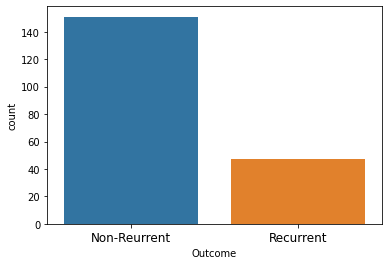

In [314]:
# Checking for imbalanced data

ax = sns.countplot(y, label="Count")
ax.set_xticklabels(['Non-Reurrent', 'Recurrent'], fontsize=12)
N, R = y.value_counts()
print('Number of Non-Recurrent: ', N)
print('Number of Recurrent: ', R)

Number of Non-Recurrent:  151
Number of Recurrent:  151


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


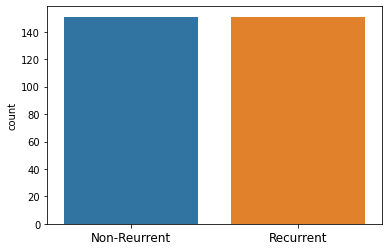

In [315]:
# Over-sampling the minority class using SMOTE

x_resampled, y_resampled = SMOTE().fit_resample(x, y)
count = Counter(y_resampled)

ax = sns.countplot(y_resampled, label="Count")
ax.set_xticklabels(['Non-Reurrent', 'Recurrent'], fontsize=12)
N, R = count[0], count[1]
print('Number of Non-Recurrent: ', N)
print('Number of Recurrent: ', R)

In [0]:
# Spliting and Scaling of data

x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size = 0.25, random_state = 0)

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

x_train = pd.DataFrame(x_train, columns=x.columns)
x_test = pd.DataFrame(x_test, columns=x.columns)
y_train = pd.Series(y_train, name=y.name, index=None)
y_test = pd.Series(y_test, name=y.name, index=None)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 <a list of 32 Text major ticklabel objects>)

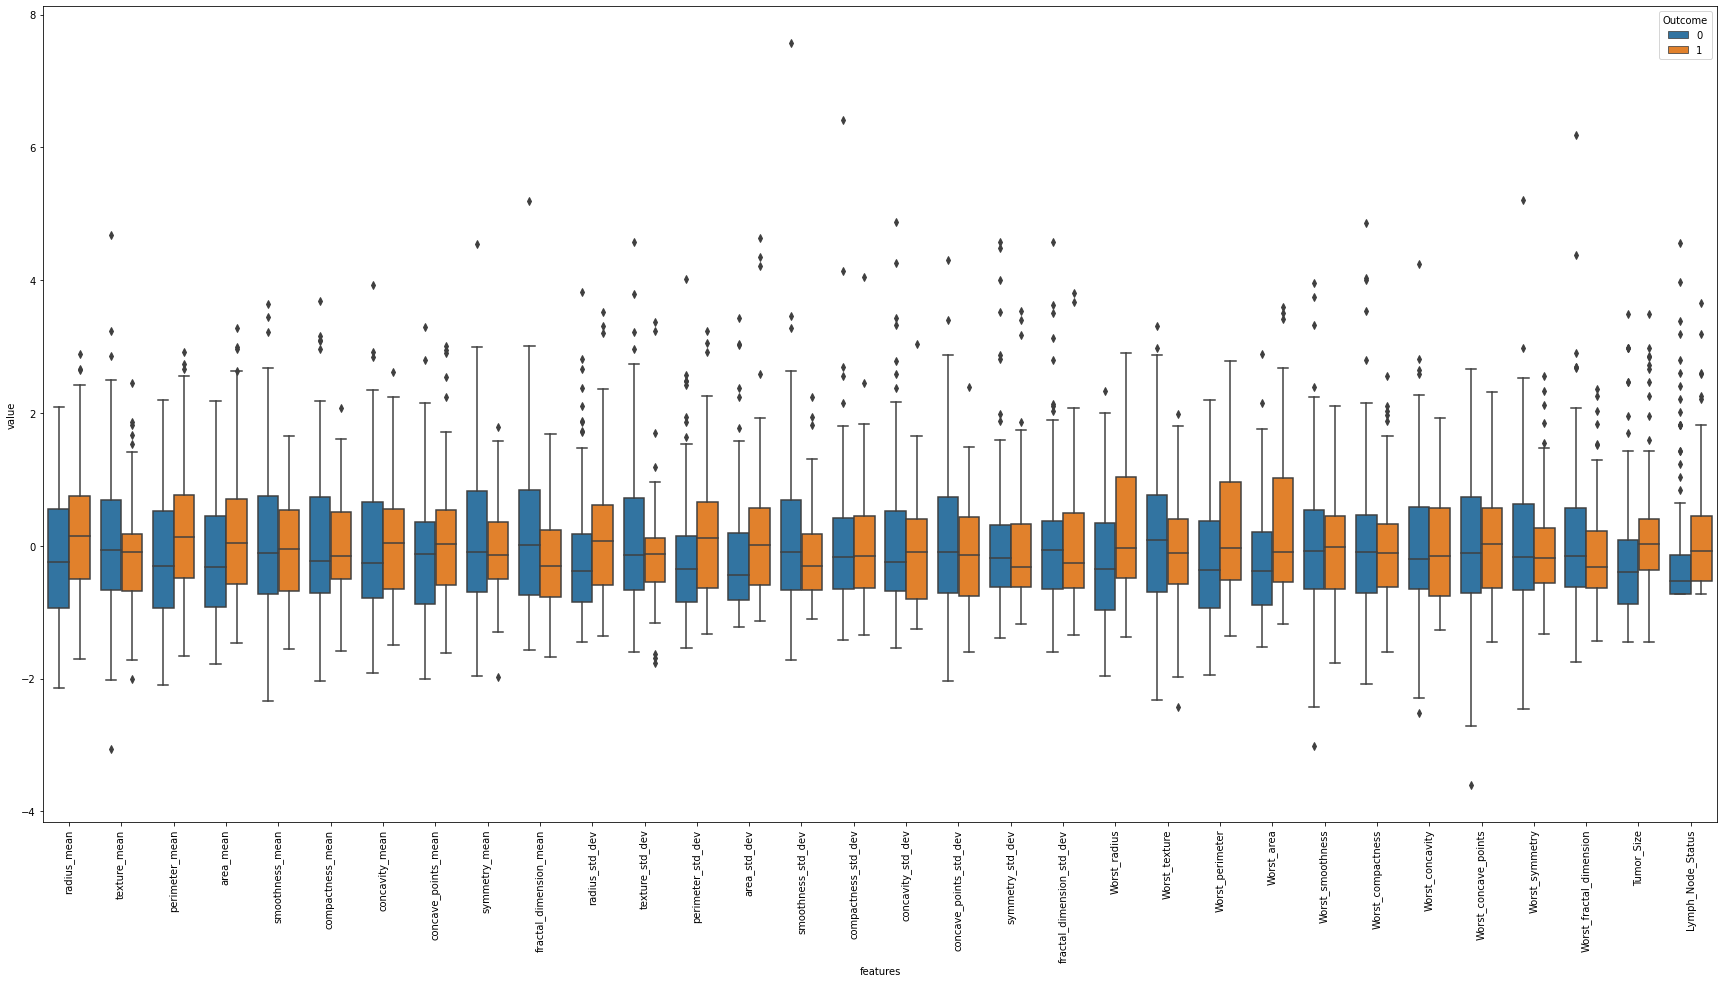

In [317]:
# Checking for variation in values of features wrt each class

data = pd.concat([y_train, x_train], axis=1)
data = pd.melt(data, id_vars="Outcome", var_name="features", value_name='value')

plt.figure(figsize=(30,15))
sns.boxplot(x="features", y="value", hue="Outcome", data=data)
plt.xticks(rotation=90)

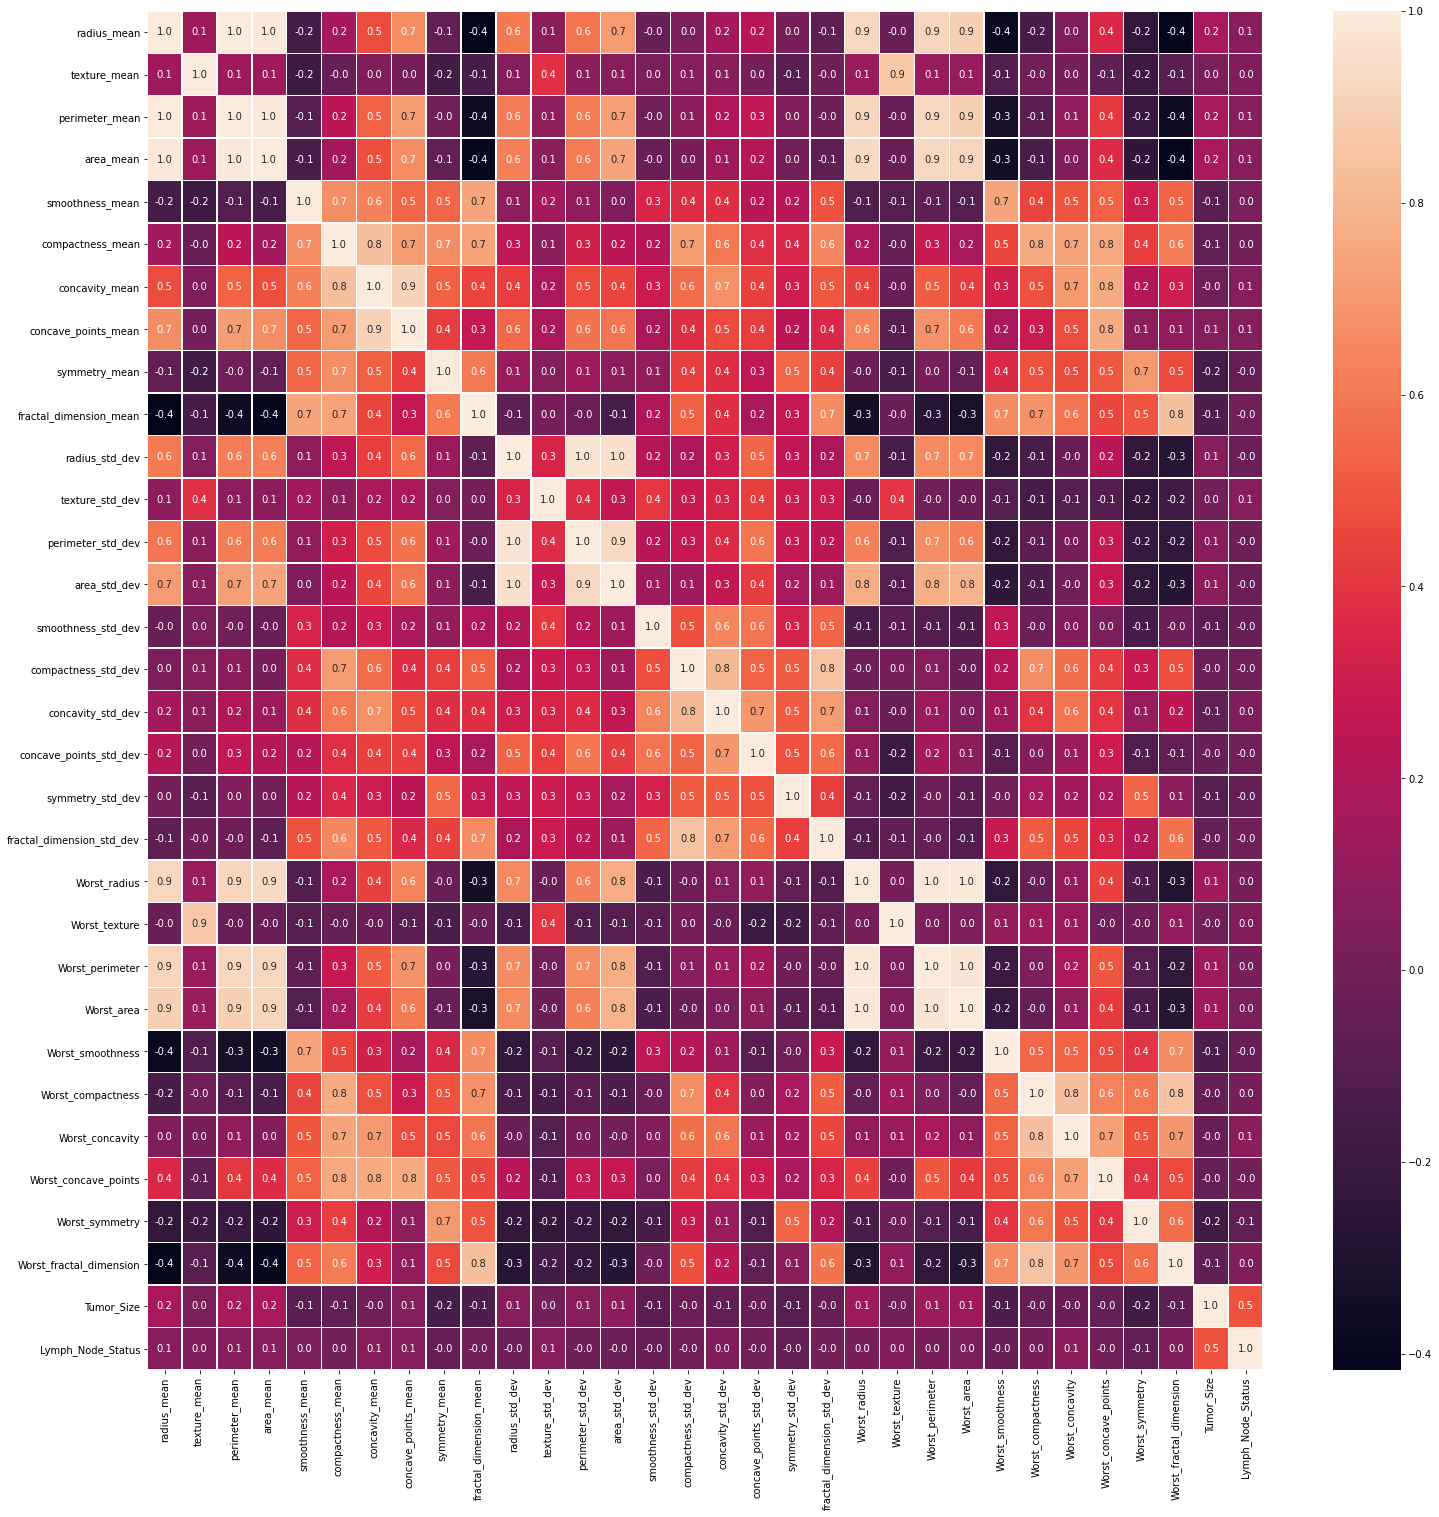

In [318]:
# Checking for correlation

f,ax = plt.subplots(figsize=(25, 25))
sns.heatmap(x.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [0]:
# radius_mean, perimeter_mean, area_mean, Worst_radius, Worst_perimeter, worst_area seems to have good correlation
# So, using only worst_area since non-recurrent semms seperated from recurrent (not totally but mostly).

# radius_std_dev, perimeter_std_dev, and area_std_dev have good correlation 
# So, using only perimeter_std_dev since non-recurrent semms seperated from recurrent (not totally but mostly).

drop_list = ['radius_mean', 'perimeter_mean', 'area_mean', 'Worst_radius', 'Worst_perimeter', 'radius_std_dev', 'area_std_dev']
new_x_train = x_train.drop(drop_list, axis=1)
new_x_test = x_test.drop(drop_list, axis=1)

In [0]:
def recall(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision_m = precision(y_true, y_pred)
    recall_m = recall(y_true, y_pred)
    return 2*((precision_m*recall_m)/(precision_m+recall_m+K.epsilon()))

In [321]:
# creating model

model = Sequential()

n_features = new_x_train.shape[1]

model.add(Dense(256, activation='relu', input_shape=(n_features,)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(192, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64))
model.add(Activation('softmax'))
model.add(Dense(output_dim=1, init='uniform', activation='sigmoid'))

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])   # tf.keras.metrics.Recall()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1, kernel_initializer="uniform")`


In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [323]:
model.fit(new_x_train, y_train, validation_split=0.2, epochs=1500, callbacks=[es, mc])

Train on 180 samples, validate on 46 samples
Epoch 1/1500
180/180 [==============================] - 1s 3ms/step - loss: 0.6928 - accuracy: 0.5111 - val_loss: 0.6934 - val_accuracy: 0.4348

Epoch 00001: val_accuracy improved from -inf to 0.43478, saving model to best_model.h5
Epoch 2/1500
180/180 [==============================] - 0s 161us/step - loss: 0.6908 - accuracy: 0.6333 - val_loss: 0.6932 - val_accuracy: 0.4348

Epoch 00002: val_accuracy did not improve from 0.43478
Epoch 3/1500
180/180 [==============================] - 0s 170us/step - loss: 0.6885 - accuracy: 0.6556 - val_loss: 0.6931 - val_accuracy: 0.4565

Epoch 00003: val_accuracy improved from 0.43478 to 0.45652, saving model to best_model.h5
Epoch 4/1500
180/180 [==============================] - 0s 167us/step - loss: 0.6865 - accuracy: 0.7611 - val_loss: 0.6927 - val_accuracy: 0.4783

Epoch 00004: val_accuracy improved from 0.45652 to 0.47826, saving model to best_model.h5
Epoch 5/1500
180/180 [=========================

In [0]:
# best_model = load_model('best_model.h5')

In [325]:
y_pred = model.predict(new_x_test)
print(y_pred)
y_pred = (y_pred > 0.5)

[[0.8601488 ]
 [0.169712  ]
 [0.85973984]
 [0.8601488 ]
 [0.86013967]
 [0.8601488 ]
 [0.16591421]
 [0.15769932]
 [0.8601488 ]
 [0.8601488 ]
 [0.15565214]
 [0.17448372]
 [0.8601488 ]
 [0.16599834]
 [0.1556521 ]
 [0.15565184]
 [0.15565184]
 [0.16589835]
 [0.8601487 ]
 [0.8601483 ]
 [0.1556519 ]
 [0.8601488 ]
 [0.8601488 ]
 [0.8601488 ]
 [0.15565184]
 [0.857318  ]
 [0.8601488 ]
 [0.8601488 ]
 [0.15565184]
 [0.8601488 ]
 [0.16590577]
 [0.8601488 ]
 [0.5050573 ]
 [0.15565184]
 [0.8601488 ]
 [0.8601483 ]
 [0.86014473]
 [0.8601476 ]
 [0.8601488 ]
 [0.16590005]
 [0.8601488 ]
 [0.4318902 ]
 [0.15565184]
 [0.8601488 ]
 [0.8601488 ]
 [0.8601365 ]
 [0.8601486 ]
 [0.16593468]
 [0.8601488 ]
 [0.8601453 ]
 [0.8601488 ]
 [0.8601484 ]
 [0.15565202]
 [0.16589895]
 [0.15565184]
 [0.8601488 ]
 [0.1556519 ]
 [0.8601488 ]
 [0.15861729]
 [0.8277893 ]
 [0.15565184]
 [0.15565187]
 [0.2086058 ]
 [0.84249115]
 [0.8601488 ]
 [0.858695  ]
 [0.8601488 ]
 [0.8601475 ]
 [0.15567732]
 [0.25949603]
 [0.15565184]
 [0.76

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.76      0.81        37
           1       0.80      0.90      0.84        39

    accuracy                           0.83        76
   macro avg       0.84      0.83      0.83        76
weighted avg       0.83      0.83      0.83        76

Confusion Matrix


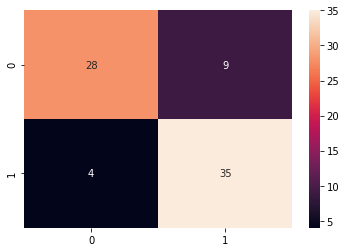

In [326]:
print('Classification Report')
print(classification_report(y_test, y_pred))

print('Confusion Matrix')
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

In [0]:
x_total = x
x_total = sc.transform(x_total)
x_total = pd.DataFrame(x_total, columns=x.columns)
x_total = x_total.drop(drop_list, axis=1)
y_total_pred = model.predict(x_total)
y_total_pred = (y_total_pred > 0.5)

In [0]:
# Model for Predicting Time

In [0]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

In [330]:
df.head()

,ID,Outcome,Time,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_std_dev,texture_std_dev,perimeter_std_dev,area_std_dev,smoothness_std_dev,compactness_std_dev,concavity_std_dev,concave_points_std_dev,symmetry_std_dev,fractal_dimension_std_dev,Worst_radius,Worst_texture,Worst_perimeter,Worst_area,Worst_smoothness,Worst_compactness,Worst_concavity,Worst_concave_points,Worst_symmetry,Worst_fractal_dimension,Tumor_Size,Lymph_Node_Status
0,119513,N,31,18.02,27.60,117.50,1013.0,0.09489,0.1036,0.1086,0.07055,0.1865,0.06333,0.6249,1.8900,3.972,71.55,0.004433,0.01421,0.03233,0.009854,0.01694,0.003495,21.63,37.08,139.70,1436.0,0.1195,0.1926,0.3140,0.1170,0.2677,0.08113,5.0,5.0
1,8423,N,61,17.99,10.38,122.80,1001.0,0.11840,0.2776,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.015870,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,3.0,2.0
2,842517,N,116,21.37,17.44,137.50,1373.0,0.08836,0.1189,0.1255,0.08180,0.2333,0.06010,0.5854,0.6105,3.928,82.15,0.006167,0.03449,0.03300,0.018050,0.03094,0.005039,24.90,20.98,159.10,1949.0,0.1188,0.3449,0.3414,0.2032,0.4334,0.09067,2.5,0.0
3,843483,N,123,11.42,20.38,77.58,386.1,0.14250,0.2839,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.018670,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,2.0,0.0
4,843584,R,27,20.29,14.34,135.10,1297.0,0.10030,0.1328,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.018850,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,3.5,0.0


In [0]:
# Spliting data into features and output labels

y_reg = df['Time']
x_reg = pd.get_dummies(data=df, columns=['Outcome']).iloc[:, 2:]

In [0]:
# Spliting and Scaling of data

x_reg_train, x_reg_test, y_reg_train, y_reg_test = train_test_split(x_reg, y_reg, test_size = 0.25, random_state = 0)

sc_reg = StandardScaler()
x_reg_train = sc_reg.fit_transform(x_reg_train)
x_reg_test = sc_reg.transform(x_reg_test)

In [0]:
svr = SVR(C=50000, gamma=0.00001)

# Used to get optimal C and gamma value
# grid = {'C' : [1e3, 5e3, 1e4, 5e4, 1e6],
#         'gamma' : [1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6]}
# grid_search = GridSearchCV(svr, grid)
# grid_search.fit(x_reg_train, y_reg_train)
# grid_search.best_estimator_

In [334]:
svr.fit(x_reg_train, y_reg_train)

SVR(C=50000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1e-05,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [335]:
print("Score on training data: " + str(svr.score(x_reg_train, y_reg_train)))
print("Score on testing data: " + str(svr.score(x_reg_test, y_reg_test)))

Score on training data: 0.3485620734028677
Score on testing data: 0.3344872424647487


In [0]:
x_reg_total = x_reg
x_reg_total = sc_reg.transform(x_reg_total)
y_reg_pred = svr.predict(x_reg_total)

In [344]:
out_df = pd.DataFrame(df.ID, columns=['ID'])
out_df['Outcome'] = y_total_pred
out_df['Outcome'] = out_df['Outcome'].astype(int)
out_df['Time'] = y_reg_pred
out_df

,ID,Outcome,Time
0,119513,0,31.101113
1,8423,0,80.149547
2,842517,0,70.490266
3,843483,0,118.990654
4,843584,1,30.024182
...,...,...,...
193,942640,0,13.597770
194,943471,0,35.517638
195,94547,0,38.845398
196,947204,1,13.791073


In [0]:
out_df.to_excel("output.xlsx") 